# Gradient Boosting Reinforcement Learning (GBRL)
GBRL is a Python-based GBT library designed and optimized for reinforcement learning (RL).
GBRL is designed to be integrated in popular RL python libraries as part of the standard RL training loop.  

## GBRL Design
The standard GBT supervised learning training procedure for K boosting iterations on a given set on inputs x and targets y is as follows:  
***For K boosting iterations***   
1. Generate predictions using current GBT ensemble.
2. Calculate loss L(y, predictions).
3. Calculate gradients of the loss function w.r.t predictions  
4. Fit a binary decision tree on the gradients and add it to the ensemble.
5. Repeat from step 1.

The training procedure is typically done end-to-end (E2E) within a GBT framework and is optimized for pre-defined loss functions.  However, E2E learning is not optimal for RL settings, where the training procedure requires interactions with an environment.

GBRL draws inspiration from PyTorch and is designed to be easily integrated into RL or other online learning settings. As such, GBRL can be viewed as a functional optimizer that incrementally adjusts a learned function by taking steps in the direction of the gradient.

## Get Started with GBRL
This is a quick tutorial demonstrating usage examples



### Basic Usage: Training, Saving, Loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import gymnasium as gym 

from sklearn import datasets
from torch.nn.functional import mse_loss 
from torch.distributions import Categorical

from gbrl import GBRL, cuda_available, ParametricActor

In [2]:
# toy dataset
X_numpy, y_numpy = datasets.load_diabetes(return_X_y=True, as_frame=False, scaled=False)

out_dim = 1 if len(y_numpy.shape) == 1  else y_numpy.shape[1]

X, y = th.tensor(X_numpy, dtype=th.float32), th.tensor(y_numpy, dtype=th.float32)
# CUDA is not deterministic
device = 'cuda' if cuda_available else 'cpu'

# initializing model parameters
tree_struct = {'max_depth': 4, # maximum tree depth
               'n_bins': 256, # maximum number of candidates to generate per numeric feature
               'min_data_in_leaf': 0, # minimum samples in each child when splitting
               'grow_policy': 'oblivious' # tree growth policy: [oblivious, greedy]
        }

optimizer = { 'algo': 'SGD', # optimizer algorithm: [SGD/Adam], Adam is available for cpu only  
              'lr': 1.0, # learning rate
              'start_idx': 0,
              'stop_idx': out_dim
            }
gbrl_params = {
               "split_score_func": "Cosine", # split score function: [L2, Cosine]
               "generator_type": "Quantile" # candidate generation policy - [Uniform, Quantile]. 
                }

In [3]:
# setting up model
gbrl_model = GBRL(
                    output_dim=out_dim,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    device=device)
# set GBRL bias
gbrl_model.set_bias_from_targets(y)

Setting GBRL device to cuda


In [4]:
def rmse_incremental_step(model, X, y):
    # forward pass - y_pred is a torch tensor with requires_grad = True by default
    y_pred = model(X)
    # calculate loss - we must scale pytorch's mse loss function by 0.5 to get the correct MSE gradient
    loss = 0.5*mse_loss(y_pred, y) 
    loss.backward()
    # perform a boosting step
    model.step(X)
    # return RMSE
    return loss.sqrt().item()

In [5]:
# Helper function to plot results
def plot_loss(n_iterations, losses, x_label, y_label):
    plt.close('all')
    _, ax = plt.subplots()

    ax.plot(np.arange(n_iterations), losses)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
        

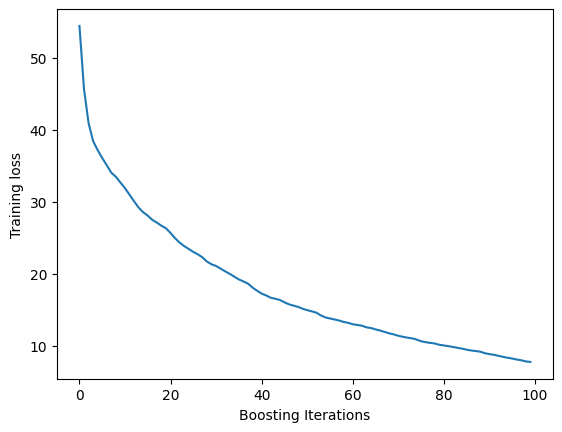

In [6]:
# training for 100 iterations
n_iterations = 100
losses = []
for _ in range(n_iterations):
    rmse_loss = rmse_incremental_step(gbrl_model, X, y)
    losses.append(rmse_loss)
    
plot_loss(n_iterations, losses, y_label='Training loss', x_label='Boosting Iterations')


GBT work with per-sample gradients but PyTorch losses are typically calculated as the expected loss and derivated w.r.t fixed parameters. GBRL internally multiplies the gradients with the number of samples when calling the step function. This allows to get similar results when using PyTorch losses on 1-dimensional outputs. However, when working with PyTorch losses and multi-output targets or different reductions one should take this into consideration.  
For example:
1. When using a summation reduction we should use:  
    `loss = 0.5*mse_loss(y_pred, y, reduction='sum') / len(y_pred)`
2. When working with multiple outputs dimensions we should use:  
    `0.5*mse_loss(y_pred, y_multi) * output_dim`.

### Saving, loading, and copying a GBRL Model

In [7]:
# Call the save_model method of a GBRL class
# GBRL will automatically save the file with the .gbrl_model ending
# The file will be saved in the current working directory
# Provide the absolute path to save the file in a different directory.
gbrl_model.save_model('gbt_model_tutorial')
# Loading a saved model is similar and is done by calling the specific class instance.
loaded_gbt_model = GBRL.load_model('gbt_model_tutorial')
# Copying a model is even more straighforward
copied_model = gbrl_model.copy()

Current GBRL Library Version 1.0.4
Reading GBRL Library Version 1.0.4
######## Loaded GBRL model ########
output_dim: 1 max_depth: 4 min_data_in_leaf: 0
generator_type: Quantile n_bins: 256 cv_beta: 0.9 split_score_func: Cosine
grow_policy: Oblivous verbose: 0 device: cpu use_cv: 0 batch_size: 5000
Loaded: 1600 leaves from 100 trees
Model has: 1 optimizers 
Setting GBRL device to cpu


### Using Manually Calculated Gradients
Alternatively GBRL can use manually calculated gradients. 

In [8]:
def manual_rmse_incremental_step(model, X, y):
    # forward pass - y_pred is a torch tensor with requires_grad = True by default
    y_pred = model(X)
    # calculate loss - we must scale pytorch's mse loss function by 0.5 to get the correct MSE gradient
    loss = 0.5*mse_loss(y_pred, y) 
    grad = y_pred - y
    # perform a boosting step
    model.step(X, grad=grad)
    print(loss.sqrt().item())
    # return RMSE
    return loss.sqrt().item()

## Multiple iterations at once (standard supervised learning)
GBRL supports training multiple boosting iterations with targets similar to other GBT libraries. This is done using the `fit` method.  
***Note: only the RMSE loss function is supported for the `fit` method***

In [9]:
gbrl_model = GBRL(
                    output_dim=1,
                    tree_struct=tree_struct,
                    optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=1,
                    device=device)
final_loss = gbrl_model.fit(X, y, iterations=100)

Setting GBRL device to cuda
Boosting iteration: 1 - MultiRMSE Loss: 45.6837
Boosting iteration: 2 - MultiRMSE Loss: 41.0103
Boosting iteration: 3 - MultiRMSE Loss: 37.8042
Boosting iteration: 4 - MultiRMSE Loss: 36.158
Boosting iteration: 5 - MultiRMSE Loss: 34.3719
Boosting iteration: 6 - MultiRMSE Loss: 33.3726
Boosting iteration: 7 - MultiRMSE Loss: 32.4287
Boosting iteration: 8 - MultiRMSE Loss: 31.5564
Boosting iteration: 9 - MultiRMSE Loss: 30.8898
Boosting iteration: 10 - MultiRMSE Loss: 30.1213
Boosting iteration: 11 - MultiRMSE Loss: 29.5286
Boosting iteration: 12 - MultiRMSE Loss: 29.1362
Boosting iteration: 13 - MultiRMSE Loss: 28.5909
Boosting iteration: 14 - MultiRMSE Loss: 28.0667
Boosting iteration: 15 - MultiRMSE Loss: 27.5238
Boosting iteration: 16 - MultiRMSE Loss: 26.9552
Boosting iteration: 17 - MultiRMSE Loss: 26.4736
Boosting iteration: 18 - MultiRMSE Loss: 25.9978
Boosting iteration: 19 - MultiRMSE Loss: 25.1341
Boosting iteration: 20 - MultiRMSE Loss: 24.7468
Bo

## RL using GBRL
Now that we have seen how GBRL is trained using incremental learning and PyTorch we can use it within an RL training loop

For simplicity, we train an agent using REINFORCE, which might not give the best results.

In [10]:
def calculate_returns(rewards, gamma):
    returns = []
    running_g = 0.0
    for reward in rewards[::-1]:
        running_g = reward + gamma * running_g
        returns.insert(0, running_g)
    return returns

def perform_rollout(rollout_buffer, agent, env):
    obs, info = env.reset(seed=0)
    rollout_buffer['rewards'] = []
    done = False
    while not done:
        action_logits = agent(obs)
        action = Categorical(logits=action_logits).sample()
        action_numpy = action.cpu().numpy()
        
        obs, reward, terminated, truncated, info = env.step(action_numpy.squeeze())
        rollout_buffer['rewards'].append(reward)
        rollout_buffer['obs'].append(obs)
        rollout_buffer['actions'].append(action)

        done = terminated or truncated

    
def reinforce_step(agent, observations, actions, returns):
     # model update
    action_logits = agent(observations)
    dist = Categorical(logits=action_logits)
    log_probs = dist.log_prob(actions)
    # calculate reinforce loss with subtracted baseline
    loss = -(log_probs*(returns - returns.mean())).mean()
    loss.backward()
    agent.step(observations)


# Helper function to plot results
def plot_returns(iterations, losses, x_label, y_label):
    plt.close('all')
    _, ax = plt.subplots()

    ax.plot(iterations, losses)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()
        



Setting GBRL device to cuda


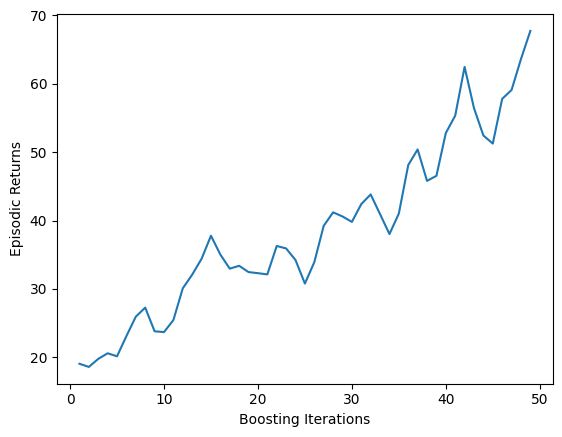

In [11]:
device = 'cuda'if th.cuda.is_available() else 'cpu'

env = gym.make("CartPole-v1")
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode-reward
num_episodes = 1000
gamma = 0.99
optimizer = { 'algo': 'SGD',
              'lr': 0.025,
              'start_idx': 0,
              'stop_idx': env.action_space.n,
            }

bias = np.zeros(env.action_space.n, dtype=np.single)
agent = ParametricActor(
                    output_dim=env.action_space.n,
                    tree_struct=tree_struct,
                    policy_optimizer=optimizer,
                    gbrl_params=gbrl_params,
                    verbose=0,
                    bias=bias, 
                    device=device)

update_every = 20
mean_returns = []
iterations = []
rollout_buffer = {'actions': [], 'obs': [], 'returns': []}

for episode in range(num_episodes):
    perform_rollout(rollout_buffer, agent, wrapped_env)
    
    rollout_buffer['returns'].extend(calculate_returns(rollout_buffer['rewards'], gamma))

    if episode % update_every == 0 and episode > 0:
        returns = th.tensor(rollout_buffer['returns'], device=device)
        actions = th.cat(rollout_buffer['actions']).to(device)
        # input to model can be either a torch tensor or a numpy ndarray
        observations = np.stack(rollout_buffer['obs'])
        reinforce_step(agent, observations, actions, returns)
        rollout_buffer = {'actions': [], 'obs': [], 'returns': []}

        mean_returns.append(np.mean(wrapped_env.return_queue))
        iterations.append(agent.get_iteration())

plot_returns(iterations, mean_returns, y_label='Episodic Returns', x_label='Boosting Iterations')

# Explainability
GBRL implements SHAP value calculation. SHAP values can be calculated over the entire ensemble as well as for individual trees.
GBRL returns SHAP values with shap: [n_samples, n_features, n_actions]

In [12]:
obs, info = wrapped_env.reset(seed=0)
# per tree shap values
tree_shap = agent.tree_shap(0, obs)
# for the entire ensemble
shap_values = agent.shap(obs)

SHAP values are calculated internally and can be plotted using the [SHAP library](https://github.com/shap/shap).


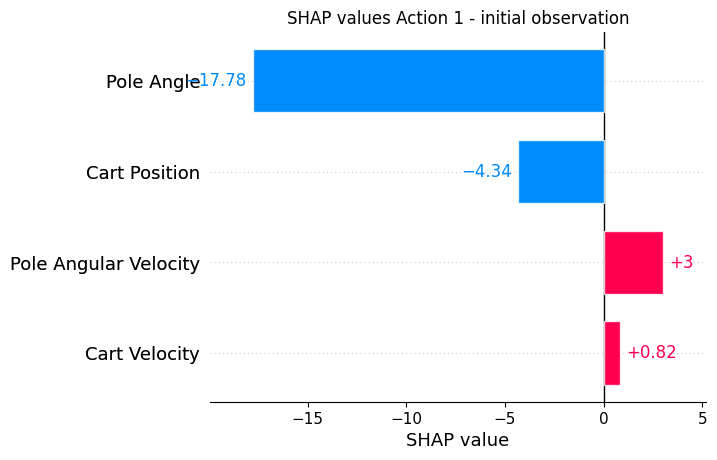

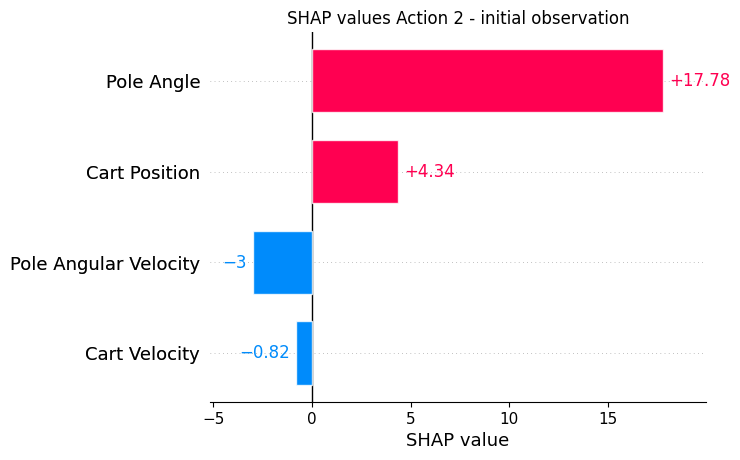

In [13]:
CARTPOLE_FEATURE_NAMES = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']
import shap
import matplotlib.pyplot as plt
plt.close('all')
explainable_values_action_1 = shap.Explanation(shap_values.squeeze()[: , 0], feature_names=CARTPOLE_FEATURE_NAMES)
explainable_values_action_2 = shap.Explanation(shap_values.squeeze()[: , 1], feature_names=CARTPOLE_FEATURE_NAMES)

fig, ax = plt.subplots()
ax.set_title("SHAP values Action 1 - initial observation")
shap.plots.bar(explainable_values_action_1, ax=ax)

fig, ax = plt.subplots()
ax.set_title("SHAP values Action 2 - initial observation")
shap.plots.bar(explainable_values_action_2, ax=ax)


plt.show()